# Jazli Muhammad Khairi Leong
# Student Number: 1007793595
# UTORid: muham283

## HW4

## Part 1: Simulation

array([[<Axes: title={'center': 'loc'}>, <Axes: title={'center': 'loc'}>],
       [<Axes: title={'center': 'df'}>, <Axes: title={'center': 'df'}>],
       [<Axes: title={'center': 'scale'}>,
        <Axes: title={'center': 'scale'}>]], dtype=object)

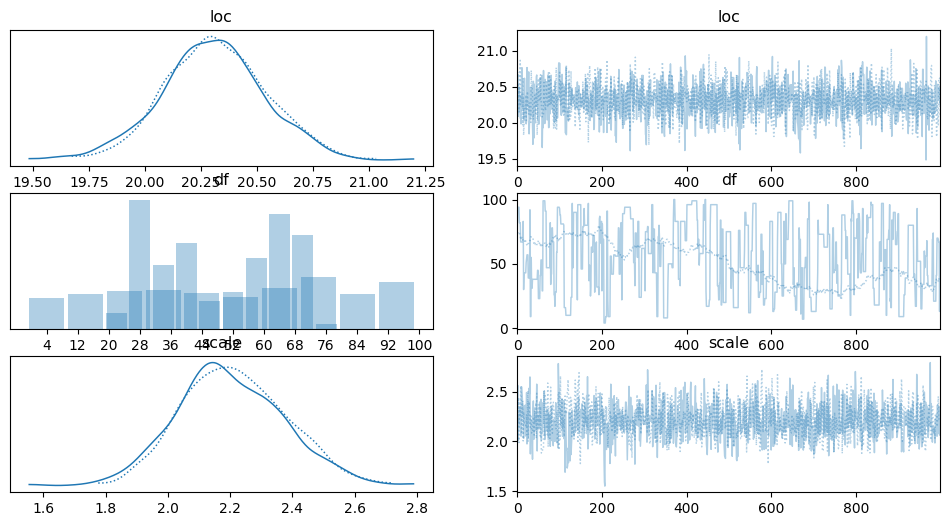

In [71]:
import pymc as pm
from scipy import stats;

n, loc_true, scale_true, df_true = 100, 20, 2, 15
x = stats.t(df = df_true, loc = loc_true, scale = scale_true).rvs(n)
np.random.seed(5999)

with pm.Model() as t_norm_half_norm_discrete:
  loc = pm.Normal("loc", mu = 0, sigma = 10)
  scale = pm.HalfNormal("scale", sigma = 5)
  df = pm.DiscreteUniform("df", lower=1, upper=100)
  x_obs = pm.StudentT("likelihood", mu=loc, sigma=scale, nu=df, observed=x)

with t_norm_half_norm_discrete:
  idata = pm.sample(random_seed=5999)

import arviz as az
az.plot_trace(idata)

array([[<Axes: title={'center': 'loc'}>, <Axes: title={'center': 'loc'}>],
       [<Axes: title={'center': 'df'}>, <Axes: title={'center': 'df'}>],
       [<Axes: title={'center': 'scale'}>,
        <Axes: title={'center': 'scale'}>]], dtype=object)

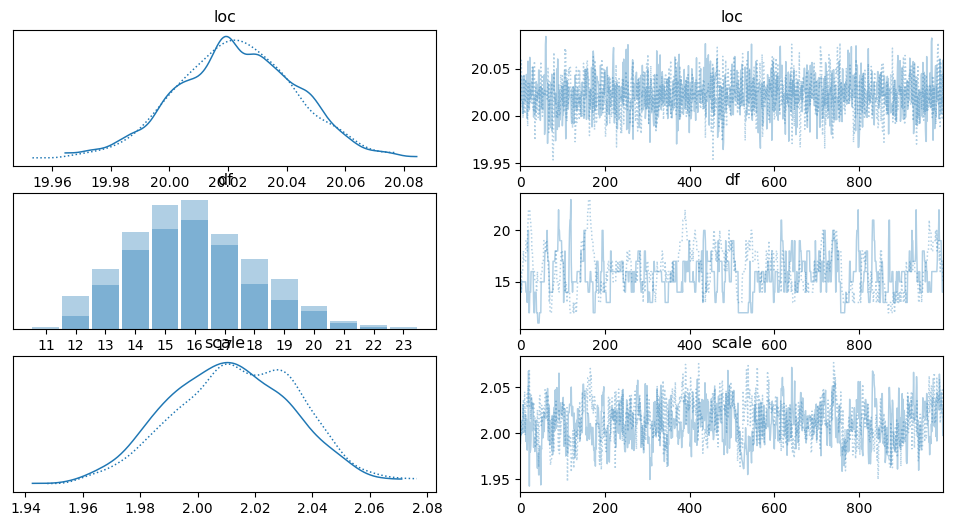

In [72]:
new_n, loc_true, scale_true, df_true =  10000, 20, 2, 15
x = stats.t(df = df_true, loc = loc_true, scale = scale_true).rvs(new_n)

large_model = pm.Model()

with large_model:
  loc = pm.Normal("loc", mu = 0, sigma = 10)
  scale = pm.HalfNormal("scale", sigma = 5)
  df = pm.DiscreteUniform("df", lower=1, upper=100)
  x_obs = pm.StudentT("likelihood", mu=loc, sigma=scale, nu=df, observed=x)

with large_model:
  large_data = pm.sample(random_seed=5999)

import arviz as az
az.plot_trace(large_data)

## Part 2: Regular

 (a) effective sample sizes; (b) chain convergence measures; (c) divergences; (d) Metropolis-Hastings acceptance rates [see below for how to access these]; and (e) any other warnings or concers provided by PyMC

### Effective Sample Sizes

In [73]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,20.31,0.23,19.9,20.75,0.0,0.00,2168.3,1433.71,1.00
df,53.73,23.25,17.0,99.00,7.7,5.63,14.2,112.28,1.19
scale,2.21,0.17,1.9,2.52,0.0,0.00,1197.6,784.38,1.00


In [74]:
az.summary(large_data, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,20.02,0.02,19.99,20.06,0.00,0.00,1764.60,1341.30,1.00
df,15.89,2.10,12.00,19.00,0.18,0.13,131.59,153.75,1.02
scale,2.01,0.02,1.97,2.05,0.00,0.00,207.49,662.22,1.01


ess_bulk lists the effective sample size

Notice that the R-hat statistic for regular sample size of the df is > 1

### Chain Convergence Measures

In [75]:
import numpy as np
import arviz as az
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata).items()})
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(large_data).items()})

HMC Split-Rhats {'loc': 1.0003, 'df': 1.1884, 'scale': 1.0016}
HMC Split-Rhats {'loc': 1.0001, 'df': 1.0187, 'scale': 1.0111}


### Divergences

In [76]:
idata.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(0)

In [77]:
large_data.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(0)

Thus we can determine that there are 0 divergences in both the small data sample and the large data sample. Since they are both empty arrays.

### Acceptance Rates

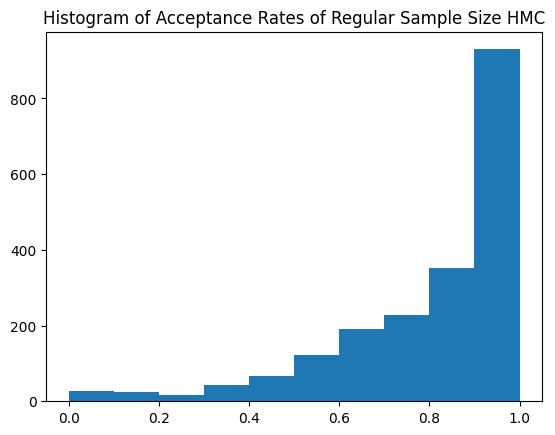

In [78]:
plt.hist(idata.sample_stats.acceptance_rate.values.flatten());
plt.title('Histogram of Acceptance Rates of Regular Sample Size HMC');

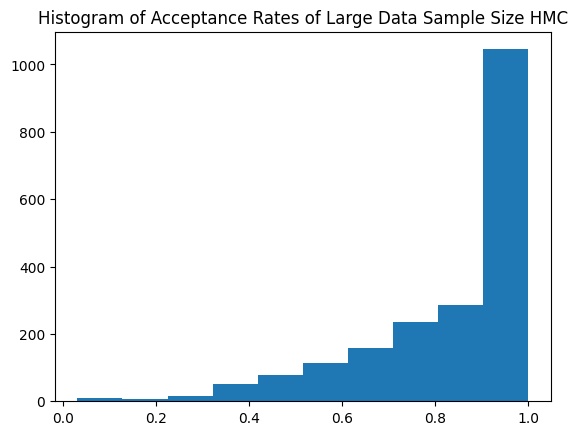

In [79]:
plt.hist(large_data.sample_stats.acceptance_rate.values.flatten());
plt.title('Histogram of Acceptance Rates of Large Data Sample Size HMC');

The large sample size model and the small sample size model have high acceptance rates

## Part 2: Eight Schools

### Sampling

In [80]:
import numpy as np

J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])


with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)


In [81]:
# This posterior distribution implied by this specification can be sampled from
# using HMC where the necessary auxiliary variables are added "under the hood"
SEED = [1007793595, 1007793596] # Set seed to student number and +1
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})


In [82]:
# As is seen above, there are many divergences because the specification above
# induces high curature in the energy, but the following alternative
# parameterization alleviates this problem.

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)


In [83]:
with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})
# Now very few divergences... problem solved!


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

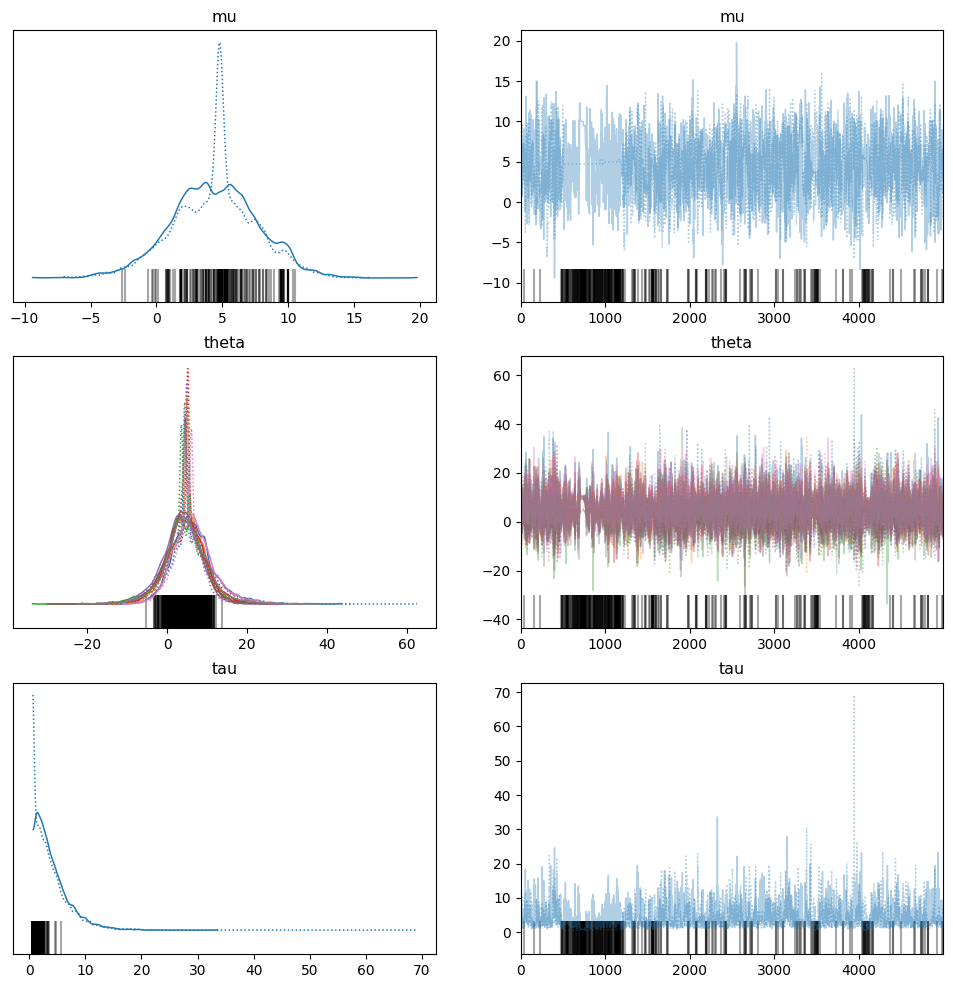

In [84]:
import matplotlib.pyplot as plt
# Convergence plots for Centered data
fig,ax = plt.subplots(3,2, figsize=(12,12))
az.plot_trace(fit_C, axes=ax[:3,:2])

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'theta_t'}>,
        <Axes: title={'center': 'theta_t'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

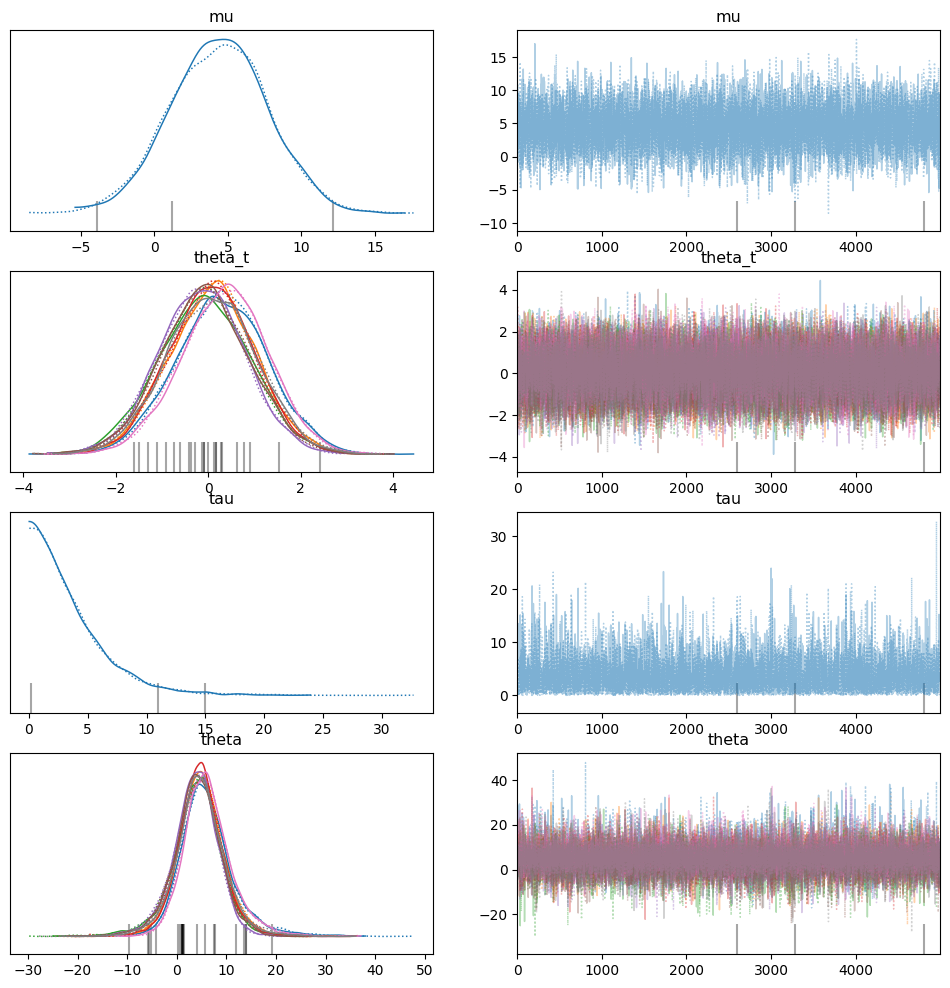

In [85]:
# Convergence plot for uncentred data
fig,ax = plt.subplots(4,2, figsize=(12,12))
az.plot_trace(fit_NC, axes=ax[:4,:2])

### Effective Sample Sizes for Centered and Non-Centered

In [86]:
import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
 pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])

Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Centered,Non-Centered
mu,1517.0,10511.0
tau,57.0,5756.0
theta[0],2024.0,10430.0
theta[1],2571.0,12432.0
theta[2],2472.0,11557.0
theta[3],2764.0,10454.0
theta[4],2063.0,10600.0
theta[5],2260.0,11770.0
theta[6],1841.0,11126.0
theta[7],2648.0,11570.0


We can see that tau in the non-centered has a significantly higher ESS than in the centered model

### Chain Convergence Measures for Centered and Non Centered

In [87]:
print("Centered HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_C).items()})

Centered HMC Split-Rhats {'mu': 1.0352, 'theta': array([1.0108, 1.039 , 1.014 , 1.0375, 1.0138, 1.033 , 1.0277, 1.0312]), 'tau': 1.0395}


In [88]:
print("Non Centered HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_NC).items()}, end=' | ')

Non Centered HMC Split-Rhats {'mu': 1.0001, 'theta_t': array([1.0004, 1.    , 1.0003, 1.0001, 1.0001, 1.    , 1.0001, 1.0009]), 'tau': 1.0, 'theta': array([0.9999, 0.9999, 1.    , 1.0007, 1.0001, 1.0001, 0.9999, 1.0002])} | 

### Divergences for Centered and Non Centered

In [89]:
fit_C.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(351)

In [90]:
fit_NC.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(3)

We can see that the non centered model had 3 divergences compared to 351 in the centered model

### Acceptance Rates for Centered and Non Centered

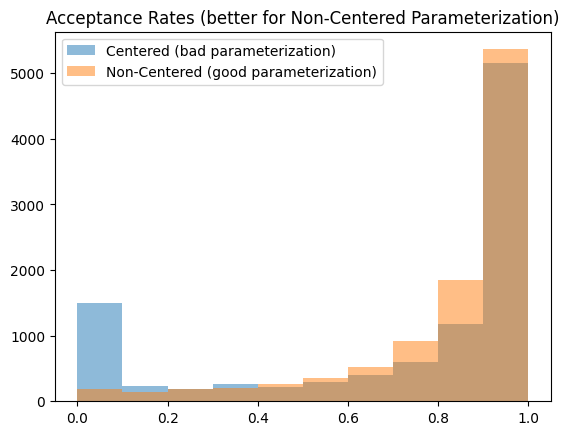

In [91]:
import matplotlib.pyplot as plt
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Centered (bad parameterization)');
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Non-Centered (good parameterization)');
plt.title('Acceptance Rates (better for Non-Centered Parameterization)'); plt.legend();


Once again we can see that the Non centered model performs better as it has better acceptance rates than the centered model as it is close to 1

## Explain why the "uncentered" paramterization of the model performs better than the "centered" parameterization

For the centered model, direct sampling of treatment effects introduces a connection between theta and tau, resulting in regions of high curvature in the energy landscape. Specifically, when tau is sampled with a small value, the density distribution of theta becomes narrow, leading to rapid changes in the log joint posterior distribution density for variations in theta. This high curvature poses challenges for the Hamiltonian Monte Carlo (HMC) algorithm, causing inefficiencies in proposal acceptance.

The "uncentered" model addresses this issue by introducing auxiliary variables that decouple the original parameters, redistributing the curvature in the energy landscape. In this parameterization, changes in theta take place on a fixed scale independent of tau, preventing rapid changes in the log joint posterior distribution density with respect to theta. The introduction of $\widetilde{\theta}$ ensures that the energy landscape is more favorable for sampling, facilitating efficient exploration of the parameter space. This decoupling enhances convergence and mixing of Markov chains, making the "uncentered" parameterization more effective, especially in complex hierarchical models. The alleviation of high curvature issues in the energy landscape contributes to the improved performance of the "uncentered" model over the "centered" model in the context of the HMC algorithm.

### Provide and interpret the diagnostic plot assessing energy proposals versus the empirical energy distribution to compare and contrast the "centered" and "uncentered" Eight Schools models in relation to you previous comparision of these two model parameterization in terms of energy function curvature and the effectiveness of the HMC algorithm

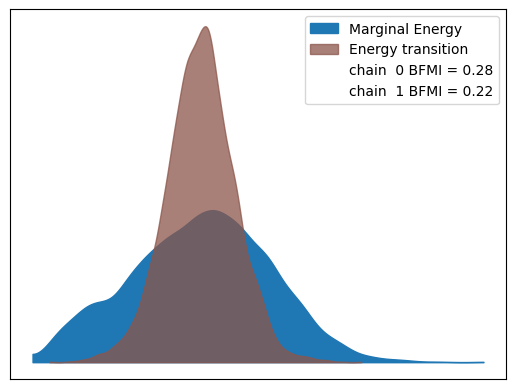

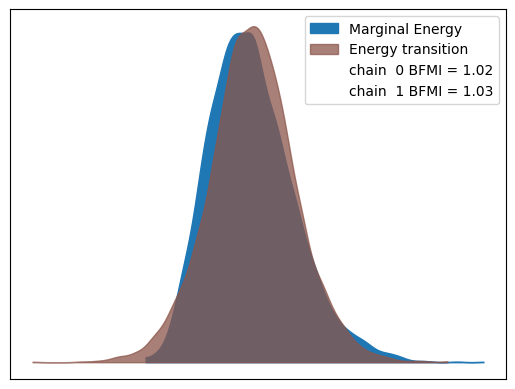

In [92]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

Using the context of "centered" Eight Schools models, the distributions exhibit considerable dissimilarity. In this setting, the energy transition (proposal) distribution is notably narrower than the marginal (empirical) energy distribution. This discrepancy implies an insufficient energy supply for exploring the entirety of the parameter space, potentially leading to bias in our posterior estimation.
Contrastingly, in "uncentered" Eight Schools models, the distributions display remarkable similarity. This uniformity provides abundant energy to traverse the complete parameter space, enhancing the likelihood of an accurate posterior estimation. We can observe these findings in the energy plots above where the centered model is much narrower as it did not explore enough of the parameter space, whereas the in the uncentered model both distributions are closer to one another while exploring more of the paramter space




